## Transfer learning and fine-tuning
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras import layers, optimizers, losses

#### Data Processing

In [2]:
dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_path = os.path.join(os.path.dirname(dataset_file), 'cats_and_dogs_filtered')

train_dir = os.path.join(data_path, 'train')
validation_dir = os.path.join(data_path, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


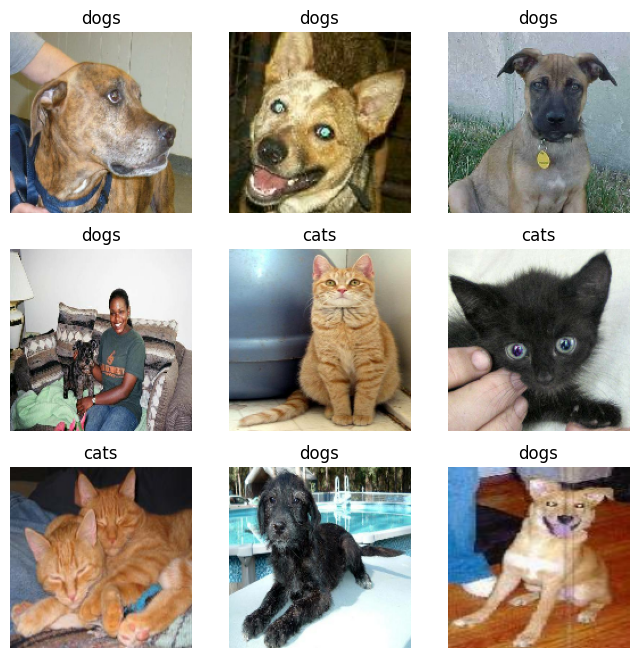

In [4]:
class_names = train_dataset.class_names

image_batch, label_batch = next(iter(train_dataset))
image_batch = tf.cast(image_batch, tf.uint8)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i])
    plt.title(class_names[label_batch[i]])
    plt.axis(False)

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_dataset)}')

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

In [7]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

#### Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

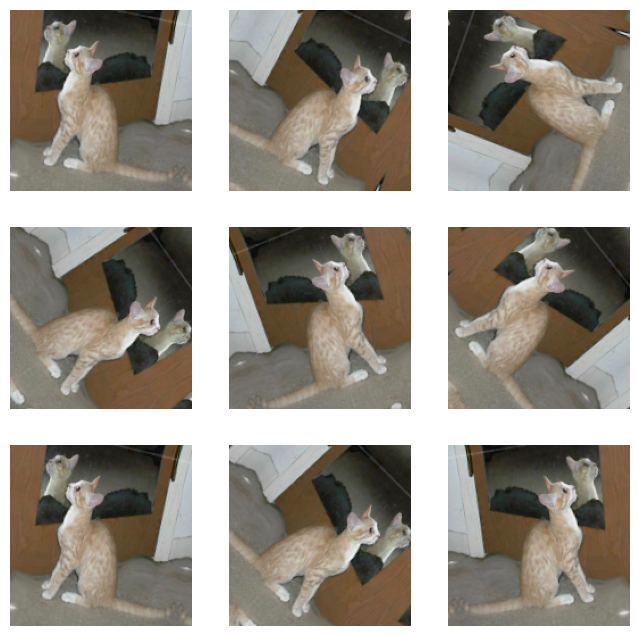

In [9]:
image_batch, _ = next(iter(train_dataset))
image = tf.expand_dims(image_batch[0], 0)

plt.figure(figsize=(8, 8))
for i in range(9):
    augmented_image = tf.cast(data_augmentation(image)[0], tf.uint8)
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis(False)

#### Rescale pixel values

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `Rescaling`.
```python
rescale = Rescaling(1./127.5, offset=-1)
```

#### Create the base model from the pre-trained convnets

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False)

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### Feature extraction

In [13]:
base_model.trainable = False

In [14]:
# base_model.summary()

In [15]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = layers.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=optimizers.Adam(learning_rate=base_learning_rate),
                loss=losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [19]:
# model.summary()

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 54ms/step - loss: 0.7257 - accuracy: 0.5495


In [22]:
print(f'initial loss: {loss0:.2f}')
print(f'initial accuracy: {accuracy0:.2f}')

initial loss: 0.73
initial accuracy: 0.55


In [23]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 14s 157ms/step - loss: 0.7074 - accuracy: 0.5920 - val_loss: 0.4802 - val_accuracy: 0.7710
Epoch 2/10
63/63 [==============================] - 9s 133ms/step - loss: 0.5305 - accuracy: 0.7110 - val_loss: 0.3471 - val_accuracy: 0.8403
Epoch 3/10
63/63 [==============================] - 9s 134ms/step - loss: 0.4192 - accuracy: 0.7980 - val_loss: 0.2646 - val_accuracy: 0.8911
Epoch 4/10
63/63 [==============================] - 10s 153ms/step - loss: 0.3574 - accuracy: 0.8295 - val_loss: 0.2199 - val_accuracy: 0.9208
Epoch 5/10
63/63 [==============================] - 9s 144ms/step - loss: 0.3129 - accuracy: 0.8610 - val_loss: 0.1865 - val_accuracy: 0.9406
Epoch 6/10
63/63 [==============================] - 9s 139ms/step - loss: 0.2805 - accuracy: 0.8735 - val_loss: 0.1656 - val_accuracy: 0.9517
Epoch 7/10
63/63 [==============================] - 8s 128ms/step - loss: 0.2636 - accuracy: 0.8890 - val_loss: 0.1426 - val_accuracy: 0.9629
Epoc

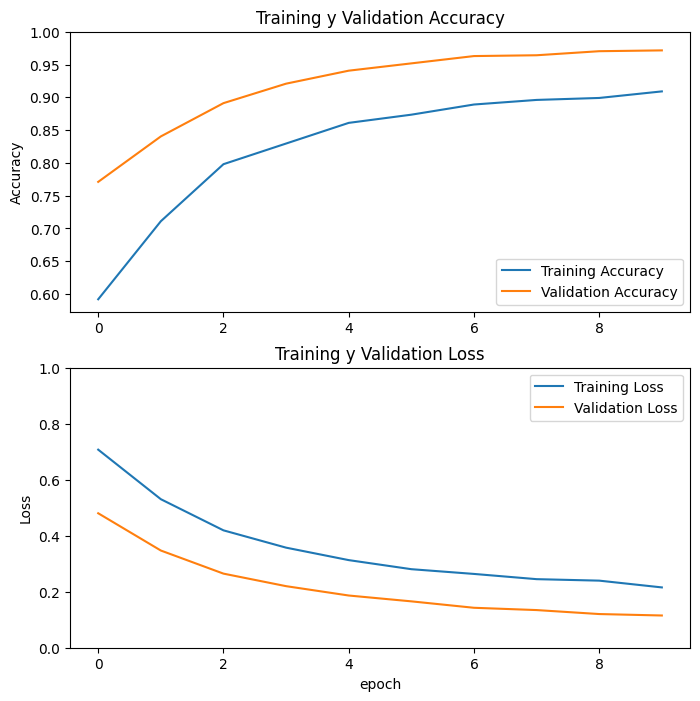

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training y Validation Accuracy')
plt.ylim([plt.ylim()[0], 1])

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training y Validation Loss')
plt.ylim([0, 1])
plt.show()

#### Fine Tuning

In [25]:
base_model.trainable = True

In [26]:
print(f'Number the layers in the base model: {len(base_model.layers)}')

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number the layers in the base model: 154


In [27]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate/10),
                loss=losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [28]:
# model.summary()

In [29]:
len(model.trainable_variables)

56

In [30]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, 
                            epochs=total_epochs, 
                            initial_epoch=history.epoch[-1],
                            validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 18s 185ms/step - loss: 0.1560 - accuracy: 0.9320 - val_loss: 0.0571 - val_accuracy: 0.9839
Epoch 11/20
63/63 [==============================] - 10s 160ms/step - loss: 0.1085 - accuracy: 0.9555 - val_loss: 0.0391 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 10s 158ms/step - loss: 0.0983 - accuracy: 0.9625 - val_loss: 0.0339 - val_accuracy: 0.9901
Epoch 13/20
63/63 [==============================] - 10s 161ms/step - loss: 0.0855 - accuracy: 0.9660 - val_loss: 0.0381 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 10s 160ms/step - loss: 0.0909 - accuracy: 0.9610 - val_loss: 0.0468 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 10s 159ms/step - loss: 0.0896 - accuracy: 0.9635 - val_loss: 0.0369 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 10s 159ms/step - loss: 0.0637 - accuracy: 0.9750 - val_loss: 0.0287 - val_accuracy:

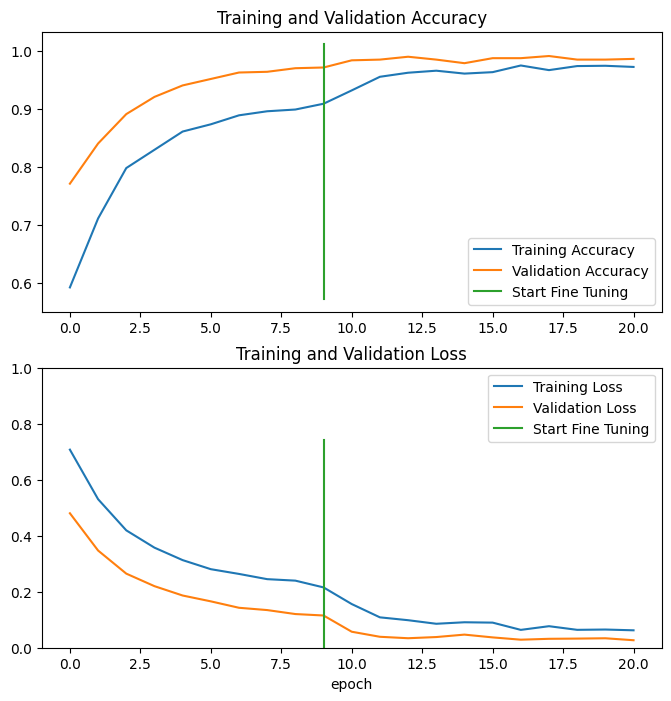

In [31]:
fine_tune_acc = acc + history_fine.history['accuracy']
fine_tune_val_acc = val_acc + history_fine.history['val_accuracy']

fine_tune_loss = loss + history_fine.history['loss']
fine_tune_val_loss = val_loss + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(fine_tune_acc, label='Training Accuracy')
plt.plot(fine_tune_val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(fine_tune_loss, label='Training Loss')
plt.plot(fine_tune_val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylim([0, 1.])
plt.show()

#### Evaluation and prediction

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy}')

6/6 [==============================] - 1s 49ms/step - loss: 0.0226 - accuracy: 0.9896
Test accuracy: 0.9895833134651184


In [60]:
image_batch, label_batch = next(iter(test_dataset))

Pedictions:
 [0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0]
Labels:
 [0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1]


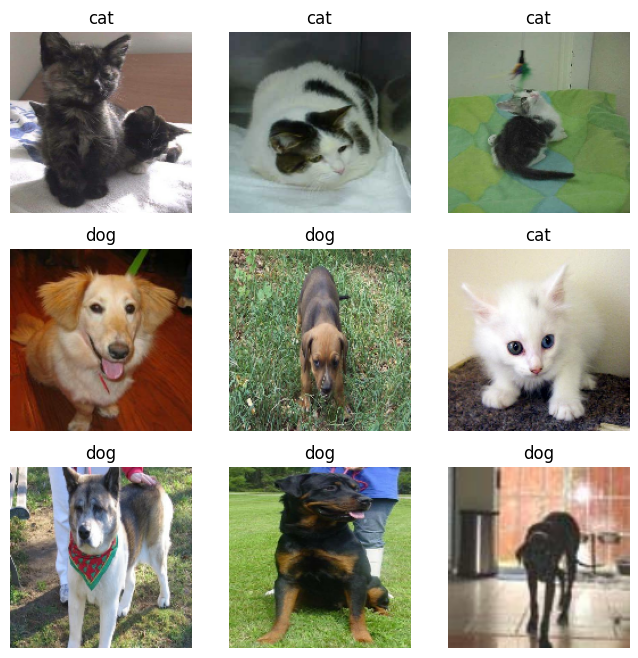

In [71]:
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Pedictions:\n', predictions.numpy())
print('Labels:\n', label_batch.numpy())

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.cast(image_batch[i], tf.uint8))
    plt.axis(False)
    plt.title(class_names[predictions[i]][:-1])